In [1]:
import cv2
import gc
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.engine import Layer
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD,RMSprop,adam
from keras.models import model_from_json
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, Callback, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, LeakyReLU, GlobalAveragePooling2D
from keras import regularizers
from keras.activations import relu, softmax, sigmoid, linear, elu
from sklearn.metrics import cohen_kappa_score
from keras.models import model_from_json

from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


In [2]:
print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


In [3]:
sys.path.append(os.path.abspath('../input/effnet/efficientnet-master/'))
# from efficientnet.keras import EfficientNetB1
# from efficientnet.keras import EfficientNetB3
# from efficientnet.keras import EfficientNetB5
from efficientnet.keras import EfficientNetB7

In [4]:
img_rows = 600
img_cols = 600
channels = 3
batch = 4
# batch = 16

# img_rows = 240
# img_cols = 240
# channels = 3
# # batch = 32
# batch = 8

In [5]:
# input_tensor = Input(shape=(img_rows, img_cols, channels))
# # model = EfficientNetB1(include_top = False, weights = 'imagenet', input_tensor=input_tensor)
# # model = EfficientNetB3(include_top = False, weights = 'imagenet', input_tensor=input_tensor)
# model = EfficientNetB7(include_top = False, weights = 'imagenet', input_tensor=input_tensor)
# # model.summary()


In [6]:
# # data = pd.read_csv('../input/aptos19/data19.csv')
# # data = pd.read_csv('../input/aptos19no-rot/data19.csv')
# data = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')

# # data['id_code'] = data['id_code'] + ".png"
# data = data[['id_code','diagnosis']]
# # data.rename(columns = {'image':'id_code', 'level':'diagnosis'}, inplace = True) 
# data.head()

In [7]:
data19 = pd.read_csv('../input/aptosdatacsv/trainLabels19.csv')
data19['id_code'] = data19['id_code'] + ".png"
data19.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [8]:
data15 = pd.read_csv('../input/aptosdatacsv/trainLabels15.csv')
data15.rename(columns = {'image':'id_code', 'level':'diagnosis'}, inplace = True) 
data15['id_code'] = data15['id_code'] + ".jpg"
data15.head()

,id_code,diagnosis
0,10_left.jpg,0
1,10_right.jpg,0
2,13_left.jpg,0
3,13_right.jpg,0
4,15_left.jpg,1


In [9]:
data = pd.concat([data19, data15])
data.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [10]:
print(len(data))

38788


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data['id_code'].values, data['diagnosis'].values, test_size=0.2, random_state=24)

In [12]:
train = pd.DataFrame({'id_code':X_train,'diagnosis':y_train.astype('int')})
train.head(5)

,id_code,diagnosis
0,31428_right.jpg,0
1,5070_left.jpg,0
2,41579_right.jpg,0
3,10260_right.jpg,0
4,28091_right.jpg,0


In [13]:
val = pd.DataFrame({'id_code':X_val,'diagnosis':y_val.astype('int')})
val.head(5)

,id_code,diagnosis
0,11943_right.jpg,0
1,42857_right.jpg,0
2,263_right.jpg,0
3,3160_right.jpg,0
4,38570_right.jpg,0


In [14]:
# len(data)
# print(len(os.listdir('../input/aptos19/data19/data19/')))
print(len(val))
print(len(train))

7758
31030


In [15]:
train.groupby(['diagnosis']).agg(['count'])

,id_code
,count
diagnosis,
0,22053
1,2273
2,5027
3,846
4,831


In [16]:
val.groupby(['diagnosis']).agg(['count'])

,id_code
,count
diagnosis,
0,5562
1,540
2,1264
3,220
4,172


In [17]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
    
def preprocess(img, sigmaX=10):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (img_rows, img_cols))
#     img = cv2.addWeighted (img,4, cv2.GaussianBlur(img, (0,0) ,10), -4, 128)
    return img

In [18]:
def rotate(img, angle):
    cols = img_cols
    rows = img_rows
    M1 = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    rot = cv2.warpAffine(img,M1,(cols,rows))    
    return rot

def flips(img):
    flip1 = cv2.flip(img, 1)
    flip2 = cv2.flip(img, -1)
    flip3 = cv2.flip(img, 0)
    return flip1, flip2, flip3

In [27]:
datagen = ImageDataGenerator(preprocessing_function=None, rescale=1/255.)

# # # train_generator = datagen.flow_from_dataframe(train, 
# # #                                                     x_col='id_code', 
# # #                                                     y_col='diagnosis',
# # #                                                     directory = '../input/aptos19no-rot/data19/data19/',
# # #                                                     target_size=(img_rows, img_cols),
# # #                                                     batch_size=batch,
# # #                                                     class_mode='categorical', 
# # #                                                     subset='training')

# # train_generator = datagen.flow_from_dataframe(df, 
# #                                                     x_col='id_code', 
# #                                                     y_col='diagnosis',
# #                                                     directory = './data19/',
# #                                                     target_size=(img_rows, img_cols),
# #                                                     batch_size=batch,
# #                                                     class_mode='categorical', 
# #                                                     subset='training')

# # val_generator = datagen.flow_from_dataframe(val, 
# #                                                 x_col='id_code', 
# #                                                 y_col='diagnosis',
# #                                                 directory = '../input/aptos2019-blindness-detection/train_images/',
# #                                                 target_size=(img_rows, img_cols),
# #                                                 batch_size=batch,
# #                                                 class_mode='categorical', 
# #                                                 subset='training')

train_generator = datagen.flow_from_dataframe(train, 
                                                    x_col='id_code', 
                                                    y_col='diagnosis',
                                                    directory = '../input/aptos600all/aptos600all/',
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch,
                                                    class_mode='raw', 
                                                    subset='training')

val_generator = datagen.flow_from_dataframe(val, 
                                                x_col='id_code', 
                                                y_col='diagnosis',
                                                directory = '../input/aptos600all/aptos600all/',
                                                target_size=(img_rows, img_cols),
                                                batch_size=batch,
                                                class_mode='raw', 
                                                subset='training')

# train_generator = datagen.flow_from_dataframe(df, 
#                                                     x_col='id_code', 
#                                                     y_col='diagnosis',
#                                                     directory = './data1915/',
#                                                     target_size=(img_rows, img_cols),
#                                                     batch_size=batch,
#                                                     class_mode='categorical', 
#                                                     subset='training')

# val_generator = datagen.flow_from_dataframe(val, 
#                                                 x_col='id_code', 
#                                                 y_col='diagnosis',
#                                                 directory = '../input/aptos600all/aptos600all/',
#                                                 target_size=(img_rows, img_cols),
#                                                 batch_size=batch,
#                                                 class_mode='categorical', 
#                                                 subset='training')

Found 31030 validated image filenames.
Found 7758 validated image filenames.


In [28]:
# del data
# gc.collect()
# del train
# gc.collect()

In [29]:
from keras.optimizers import Adam

# input_tensor = Input(shape=(img_rows, img_cols, channels))
# # model = EfficientNetB1(include_top = False, weights = 'imagenet', input_tensor=input_tensor)
# # model = EfficientNetB3(include_top = False, weights = 'imagenet', input_tensor=input_tensor)
# model = EfficientNetB5(include_top = False, weights = 'imagenet', input_tensor=input_tensor)
# model = EfficientNetB7(include_top = False, weights = 'imagenet', input_tensor=input_tensor)

# x = model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.3)(x)
# x = Dense(1024, activation=relu)(x)
# x = Dropout(0.2)(x)
# x = Dense(512, activation=relu)(x)
# # x = Dropout(0.2)(x)
# x = BatchNormalization()(x)
# # outputs = Dense(5, activation='softmax')(x)
# outputs = Dense(1, activation='linear') (x)


# model = Model(inputs=model.input, outputs=outputs)

# json_file = open('../input/b7weightshalftrain/model_b3.json', 'r')
json_file = open('../input/b7weights14epochs/model_b7.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# loaded_model.load_weights('../input/b5halftrain2/weights_kappa_b5 1.h5')
# loaded_model.load_weights('../input/b5halftrain2/weights_best_val_b5 1.h5')
# loaded_model.load_weights('../input/b5weights/weights_best_val_b5 2.h5')
# loaded_model.load_weights('../input/b5weights/weights_kappa_b5 2.h5')
# model.load_weights('../input/b7weightshalftrain/weights_best_b7.h5')
model.load_weights('../input/b7weights14epochs/weights_kappa_b7.h5')
print("Loaded model from disk")

model.compile(loss='mse',optimizer=Adam(lr=0.0001))

Loaded model from disk


In [30]:
def get_preds_and_labels(model, generator):
    """
    Get predictions and labels from the generator
    
    :param model: A Keras model object
    :param generator: A Keras ImageDataGenerator object
    
    :return: A tuple with two Numpy Arrays. One containing the predictions
    and one containing the labels
    """
    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / batch))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)
    # Flatten list of numpy arrays
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()

class Metrics(Callback):
    """
    A custom Keras callback for saving the best model
    according to the Quadratic Weighted Kappa (QWK) metric
    """
    def on_train_begin(self, logs={}):
        """
        Initialize list of QWK scores on validation data
        """
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        """
        Gets QWK score on the validation data
        
        :param epoch: The current epoch number
        """
        # Get predictions and convert to integers
        y_pred, labels = get_preds_and_labels(model, val_generator)
        y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)
        # We can use sklearns implementation of QWK straight out of the box
        # as long as we specify weights as 'quadratic'
        _val_kappa = cohen_kappa_score(labels, y_pred, weights='quadratic')
        self.val_kappas.append(_val_kappa)
        print(f"val_kappa: {round(_val_kappa, 4)}")
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save_weights("./weights_kappa_b7.h5")
        return

# For tracking Quadratic Weighted Kappa score
kappa_metrics = Metrics()

# Loss is calculated using categorical cross entropy
# ReducedLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=5*10**-7)
def schedule(epoch, lr):
    if epoch <= 4:
        lr = 0.000001
    elif epoch > 4 and epoch <= 7:
        lr = 0.000001
    elif epoch > 7:
        lr = 0.0000005
#     else:
#         lr = 1e-6
    return lr
LRS = LearningRateScheduler(schedule, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto')
filepath="./weights_best_b7.h5"
# filepath="./weights_best_b1.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.compile(loss='mse', optimizer = adam(lr=0.00005), metrics = ['accuracy'])

In [31]:
# Begin training
hist = model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // batch,
                    epochs=5,
                    validation_data=val_generator,
                    validation_steps = val_generator.samples // batch,
                    callbacks=[early_stop,LRS, checkpoint, kappa_metrics],
                    shuffle = True)

Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 1e-06.
3878/3878 [==============================] - 3666s 945ms/step - loss: 0.2556 - accuracy: 0.7417 - val_loss: 0.1976 - val_accuracy: 0.7937

Epoch 00001: val_loss improved from inf to 0.19756, saving model to ./weights_best_b7.h5
val_kappa: 0.7937
Validation Kappa has improved. Saving model.
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 1e-06.
3878/3878 [==============================] - 3499s 902ms/step - loss: 0.2477 - accuracy: 0.7499 - val_loss: 0.9882 - val_accuracy: 0.7996

Epoch 00002: val_loss did not improve from 0.19756
val_kappa: 0.7936
Epoch 3/5

Epoch 00003: LearningRateScheduler setting learning rate to 1e-06.
3878/3878 [==============================] - 3489s 900ms/step - loss: 0.2498 - accuracy: 0.7512 - val_loss: 0.0641 - val_accuracy: 0.7982

Epoch 00003: val_loss improved from 0.19756 to 0.06415, saving model to ./weights_best_b7.h5
val_kappa: 0.7938
Validation Kappa 

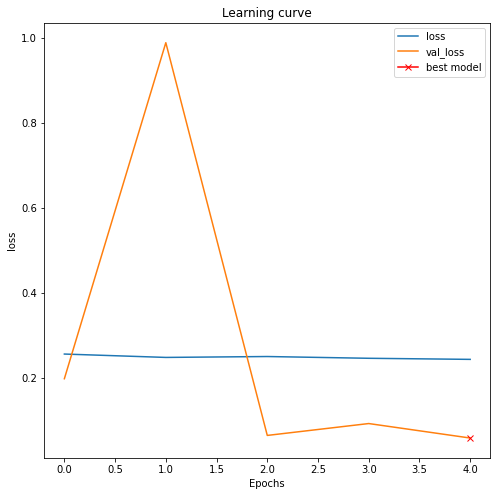

In [32]:
# visualizing losses and accuracy
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(hist.history["val_loss"]), np.min(hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()

In [34]:
# Save model and weights
model_json = model.to_json()
with open("./model_b7.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to H5
model.save_weights("./weights_b7.h5")
print("Saved model to disk")

Saved model to disk
